### Dependencies

!pip install tensorflow

!pip install numpy scipy matplotlib

!pip install opencv-python

### Make predictions

In [1]:
import sys
sys.path.append("../Library")

from tubecam.tensorflow_utils import load_session_with_graph
from tubecam.tensorflow_utils import get_confusion_matrix
from tubecam.tensorflow_utils import predict
from tubecam.image_utils import load_images_labels_and_paths

def prediction_success(graph_path, images, image_labels, pred_labels, corresponding_data):
    with load_session_with_graph(graph_path) as session:
        predictions = predict(session, images)
    return get_confusion_matrix(predictions, image_labels, pred_labels, images_paths)


### Load Events

In [2]:
import sys
sys.path.append("../Library")

from tubecam.tensorflow_utils import load_event_scalars
import os

def load_tensorlogs(root_log_path):
    train_log_path = os.path.join(root_log_path, "train")
    train_filename = os.listdir(train_log_path)[0]
    train_log_path = os.path.join(train_log_path, train_filename)

    validation_log_path = os.path.join(root_log_path, "validation")
    validation_filename = os.listdir(validation_log_path)[0]
    validation_log_path = os.path.join(validation_log_path, validation_filename)

    train_events = load_event_scalars(train_log_path, 'cross_entropy_1', 'accuracy_1')
    validation_events = load_event_scalars(validation_log_path, 'cross_entropy_1', 'accuracy_1')
    
    crossentropy_events = (train_events[0], validation_events[0])
    accuracy_events = (train_events[1], validation_events[1])
    
    return crossentropy_events, accuracy_events

### Prepare Plots

#### Eventplots

In [3]:
import matplotlib.pyplot as plt

def events_to_plotvalues(events):
    x = [event.step for event in events]
    y = [event.value for event in events]
    return x, y

def plot_event(events, title="", x_label="", y_label="", axis=""):
    fig = plt.figure(1)
    fig.suptitle(title, fontsize=20, x=1) #x=1, Ort auf der X-Achse. 1 = Centered? :P
    
    #Training
    train_x, train_y = events_to_plotvalues(events[0])
    plt.subplot(121)
    plt.title("Training")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if axis != "":
        plt.axis(axis)
    plt.plot(train_x, train_y, 'r')

    #Validation
    validation_x, validation_y = events_to_plotvalues(events[1])
    plt.subplot(122)
    plt.title("Validation")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if axis != "":
        plt.axis(axis)
    plt.plot(validation_x, validation_y, 'b')

    plt.subplots_adjust(top=0.8, bottom=0.0, left=0.00, right=2, hspace=0.25, wspace=0.2)
    plt.show()


def plot_crossentropy(crossentropy_events):
    plot_event(crossentropy_events,
               axis="", # [-1000, 50000, 0, 1.4] oder [-100, 2000, 0, 1.4]
               title="Crossentropy",
               x_label = "Steps",
               y_label = "Loss")

def plot_accuracy(accuracy_events):
        plot_event(accuracy_events,
               axis="", # "" oder [-100, 2000, 0, 1.4]
               title="Accuracy",
               x_label = "Steps",
               y_label = "Accuracy")

#### Various other Plots

In [4]:
import matplotlib.pyplot as plt

def get_accuracy_list(confusion_matrix):
    accuracy_list = []
    
    for rowIndex in range(len(confusion_matrix)):
        class_total = sum(confusion_matrix[rowIndex])
        class_found = confusion_matrix[rowIndex][rowIndex]
        accuracy = float(class_found) / class_total * 100
            
        accuracy_list.append(accuracy)
    
    return accuracy_list

def plot_class_accuracy(confusion_matrix, label_lines):
    keys = label_lines
    results = get_accuracy_list(confusion_matrix)

    x = range(len(keys))
    y = results
    labels = ['{0:.2f}%'.format(result) for result in results]

    plt.barh(x, y, color="blue")
    plt.xlim([0, 100])
    plt.yticks(x, keys)
    
    ax = plt.gca()
    rects = ax.patches
    for rect, label in zip(rects, labels):
        width = rect.get_width()
        ax.text(width + 6, rect.get_y() + rect.get_height()/2, label, ha='center', va='bottom')
    
    plt.show()

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(confusion_matrix, label_lines):
    accuracy_list = np.array(get_accuracy_list(confusion_matrix))
    accuracy_average = np.average(accuracy_list)
    accuracy_list = np.array(accuracy_list, dtype=np.str) # Have to stringify (floats)
    accuracy_list_transposed = accuracy_list.reshape(len(accuracy_list), 1)
    confusion_matrix = np.append(confusion_matrix, accuracy_list_transposed, 1)
    total_row = [[""]*len(label_lines) + [accuracy_average]]
    confusion_matrix = np.append(confusion_matrix, total_row, 0)

    colLabels = label_lines + ["Accuracy"]
    rowLabels = label_lines + ["Total"]
    rows = len(label_lines)+2
    hcell, wcell = 1, 0.6
    fig=plt.figure(figsize=(rows*wcell, rows*hcell))
    ax = fig.add_subplot(111, frame_on=False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.text(-2.2, 0.4, 'Ground Truth',
        horizontalalignment='right',
        verticalalignment='center',
        fontsize='25',
        rotation='vertical',
        transform=ax.transAxes)
    
    ax.text(0.6, 1, 'Predicted as',
        horizontalalignment='right',
        verticalalignment='center',
        fontsize='25',
        transform=ax.transAxes)
    
    table = ax.table(cellText=confusion_matrix,
              colLabels=colLabels,
              rowLabels=rowLabels,
              loc='center')
    table.scale(4,4)
    table.auto_set_font_size(False)
    table.set_fontsize(14)
    plt.show()
    

In [6]:
def print_confusion_matrix_path(confusion_matrix_paths, label_lines, show_wrong=True, show_true=True, categorized=True):
    for rowIndex in range(len(confusion_matrix_paths)):
        ground_truth = label_lines[rowIndex]
        for colIndex in range(len(confusion_matrix_paths[rowIndex])):
            predicted_as = label_lines[colIndex]
            if (((show_true and ground_truth == predicted_as)
                or (show_wrong and ground_truth != predicted_as))
                and len(confusion_matrix_paths[rowIndex][colIndex]) != 0):
                    
                if categorized:
                    print("{0} predicted as {1}:".format(ground_truth, predicted_as))
                print("\n".join(confusion_matrix_paths[rowIndex][colIndex]))
                if categorized:
                    print

### Do plots

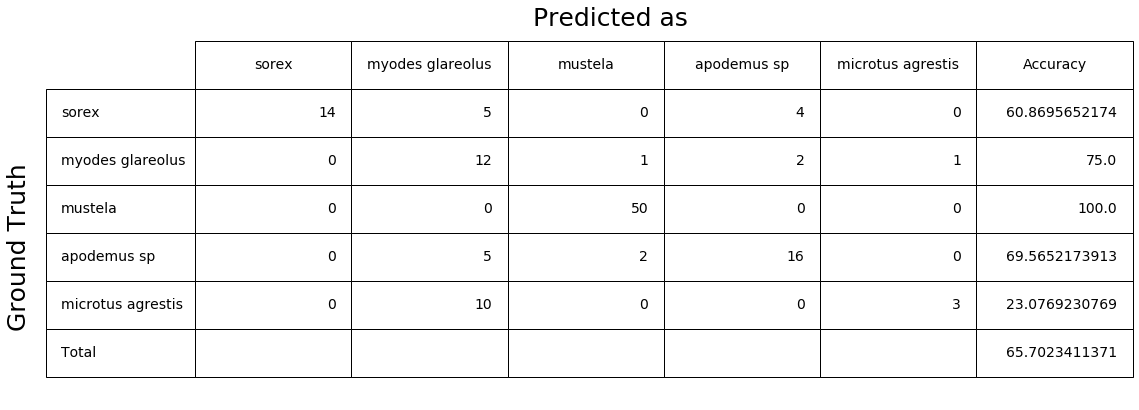

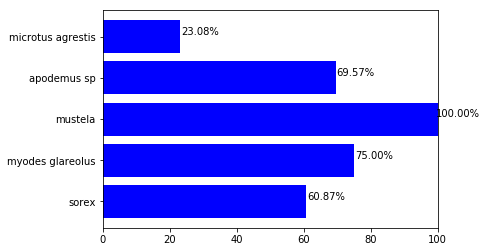

In [7]:
import tensorflow as tf

#Tensorboard
print("On Tensorboard")
root_log_path = "../Training/Logs/50k/"
crossentropy_events, accuracy_events = load_tensorlogs(root_log_path)
plot_crossentropy(crossentropy_events)
plot_accuracy(accuracy_events)

#Testset evaluation
print("On Testset evaluation")
graph_path = "../Training/Models/retrained_graph_5_classes_50k.pb"
labels_path = "../Training/Models/retrained_labels_5_classes_50k.txt"
images_path = "../Resources/Pictures/Test/testset/5/"
images, image_labels, images_paths = load_images_labels_and_paths(images_path)
pred_labels = [line.rstrip().lstrip() for line in tf.gfile.GFile(labels_path)]

confusion_matrix, confusion_matrix_paths = prediction_success(graph_path, images, image_labels, pred_labels, images_paths)
plot_confusion_matrix(confusion_matrix, pred_labels)
plot_class_accuracy(confusion_matrix, pred_labels)


In [8]:
print_confusion_matrix_path(confusion_matrix_paths, pred_labels, show_true=False, categorized=True)

sorex predicted as myodes glareolus:
/notebooks/shared/Pictures/Test/testset/5/sorex/EK000082.JPG
/notebooks/shared/Pictures/Test/testset/5/sorex/EK000127.JPG
/notebooks/shared/Pictures/Test/testset/5/sorex/EK000268.JPG
/notebooks/shared/Pictures/Test/testset/5/sorex/EK000535.JPG
/notebooks/shared/Pictures/Test/testset/5/sorex/EK000770.JPG

sorex predicted as apodemus sp:
/notebooks/shared/Pictures/Test/testset/5/sorex/EK000512.JPG
/notebooks/shared/Pictures/Test/testset/5/sorex/EK000516.JPG
/notebooks/shared/Pictures/Test/testset/5/sorex/EK000555_3.JPG
/notebooks/shared/Pictures/Test/testset/5/sorex/EK000718.JPG

myodes glareolus predicted as mustela:
/notebooks/shared/Pictures/Test/testset/5/myodes glareolus/13261906ZP.jpg

myodes glareolus predicted as apodemus sp:
/notebooks/shared/Pictures/Test/testset/5/myodes glareolus/EK000030_60.jpg
/notebooks/shared/Pictures/Test/testset/5/myodes glareolus/WP147, NI18 R, CA09, 10092014EK000021.AVI_63_1.jpg

myodes glareolus predicted as micro